In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from pprint import pprint

from sklearn.datasets import fetch_20newsgroups

import re
import nltk
from nltk.corpus import stopwords

import time
from sentence_transformers import SentenceTransformer

d:\Ent\Softwares\Software_Installs\Python\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
categories = [
 'comp.os.ms-windows.misc',
 'rec.sport.hockey',
 'soc.religion.christian',
]

dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, remove=('headers', 'footers', 'quotes'))
data = {'text': dataset.data, 'target': dataset.target}
df = pd.DataFrame(data)

In [3]:
def preprocess_text(text: str) -> str:
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    
    # remove stopwords
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
    text = " ".join(tokens)
    text = text.lower().strip()
    
    return text

In [4]:
df['text_cleaned'] = df['text'].apply(lambda text: preprocess_text(text))
df = df[df['text_cleaned'] != '']

In [5]:
st = time.time()

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
df['encode_transforemers'] = df['text_cleaned'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))

X_transformers = np.vstack(df['encode_transforemers'])

truelabel = df['target'].values.tolist()

Elapsed time: 43.26 seconds


In [6]:
print(X_transformers)

[[-0.19556537 -0.05869426 -0.10201937 ... -0.07405631  0.01389435
   0.21891697]
 [-0.71055967 -0.324534    0.05747799 ... -0.22413766  0.61486953
   0.2831625 ]
 [-0.2597005  -0.27519357  0.17308056 ...  0.13216835  0.1410994
   0.21804571]
 ...
 [-0.28117594  0.85472816 -0.59353155 ... -0.1492701  -0.30565968
  -0.16400479]
 [-0.545767    0.5959249  -0.11942709 ... -0.00458297  0.10226098
  -0.09212889]
 [-0.8401026  -0.15221317 -0.55175394 ...  0.27727467  0.19680208
   0.05077566]]


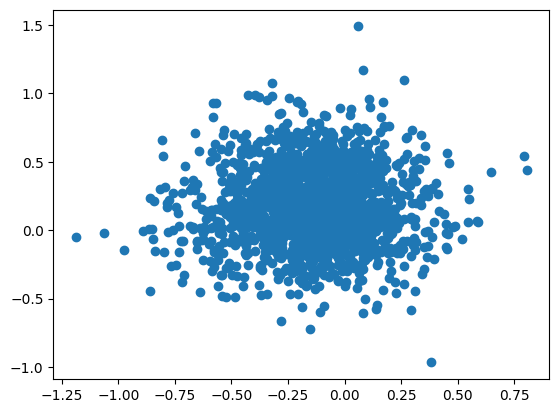

In [7]:
plt.scatter(X_transformers[:,0], X_transformers[:,1])
plt.show()

In [8]:
cl = {-1: 'k',
 0 : 'r',
 1 : 'g',
 2 : 'b',
 3 : 'c',
 4 : 'm',
 5 : 'y'}

In [9]:
from sklearn.cluster import DBSCAN 

db_default = DBSCAN().fit(X_transformers) 
db_labels = db_default.labels_

print("DBSCAN")
print(np.unique(db_default.labels_))
print(db_default.labels_)

DBSCAN
[-1]
[-1 -1 -1 ... -1 -1 -1]


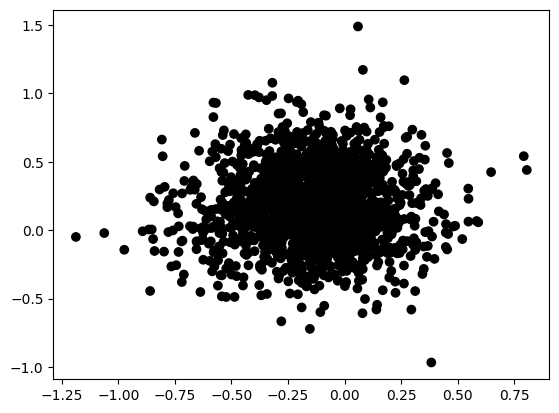

In [10]:
cvec = [cl[label] for label in db_labels]
plt.scatter(X_transformers[:,0], X_transformers[:,1], c = cvec) 
plt.show()

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X_transformers)
kmeans_labels = kmeans.labels_

print("Kmeans")
print(kmeans.labels_)
print(np.unique(kmeans.labels_))

Kmeans
[0 0 0 ... 1 1 0]
[0 1]


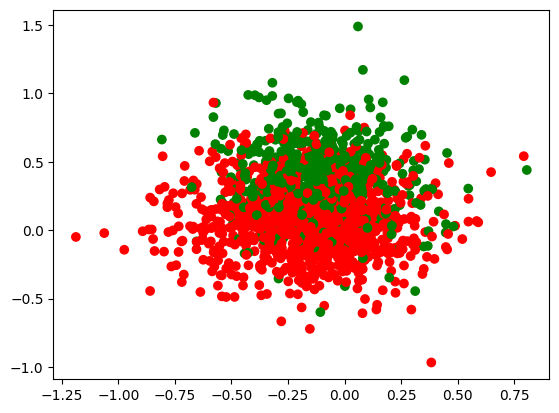

In [12]:
cvec = [cl[label] for label in kmeans_labels]
plt.scatter(X_transformers[:,0], X_transformers[:,1], c = cvec) 
plt.show()

In [14]:
from sklearn import metrics
print("DBSCAN", metrics.rand_score(truelabel, db_labels))
print("KMEANS", metrics.rand_score(truelabel, kmeans_labels))

DBSCAN 0.3330441614345039
KMEANS 0.7542646252979197
